In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from pycocotools.coco import COCO
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get the LIVECell data

- instructions here - https://sartorius-research.github.io/LIVECell/

In [3]:
!curl -H "GET /?list-type=2 HTTP/1.1" \
     -H "Host: livecell-dataset.s3.eu-central-1.amazonaws.com" \
     -H "Date: 20161025T124500Z" \
     -H "Content-Type: text/plain" http://livecell-dataset.s3.eu-central-1.amazonaws.com/ > files.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25149    0 25149    0     0  43360      0 --:--:-- --:--:-- --:--:-- 43435


In [4]:
!grep -oPm1 "(?<=<Key>)[^<]+" files.xml | sed -e 's/^/http:\/\/livecell-dataset.s3.eu-central-1.amazonaws.com\//' > urls.txt

In [5]:
for url in open('urls.txt'):
    if 'livecell_coco_val.json' in url:
        !wget $url
    if '/images.zip' in url: # will take a few minutes
        !wget $url

--2023-06-27 11:32:43--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.171.66
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.171.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97272542 (93M) [application/json]
Saving to: ‘livecell_coco_val.json’

livecell_coco_val.j 100%[===================>]  92.77M  19.2MB/s    in 5.9s    

2023-06-27 11:32:49 (15.8 MB/s) - ‘livecell_coco_val.json’ saved [97272542/97272542]

--2023-06-27 11:32:49--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 3.5.136.126
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (li

In [6]:
!unzip -q images.zip

In [7]:
annotation_file = 'livecell_coco_val.json'
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=4.52s)
creating index...
index created!


In [8]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]

In [9]:
image_ids = coco.getImgIds()
images = coco.loadImgs(image_ids)
image_file_paths = [image['file_name'] for image in images]

In [12]:
def plot_image_with_annotations(coco, image_id):

    # Load the image
    image_info = coco.loadImgs(image_id)[0]
    image_path = image_info['file_name']
    image_path = 'images/livecell_train_val_images/' + image_path
    image = Image.open(image_path)

    # Get the annotation IDs for the image
    annotation_ids = coco.getAnnIds(imgIds=image_id)

    # Load the annotations
    annotations = coco.loadAnns(annotation_ids)

    # Create the figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Plot the image with annotations
    axes[1].imshow(image)
    axes[1].axis('off')
    axes[1].set_title('Image with Annotations')
    coco.showAnns(annotations)

    # Adjust the spacing between subplots
    plt.tight_layout()

    return fig

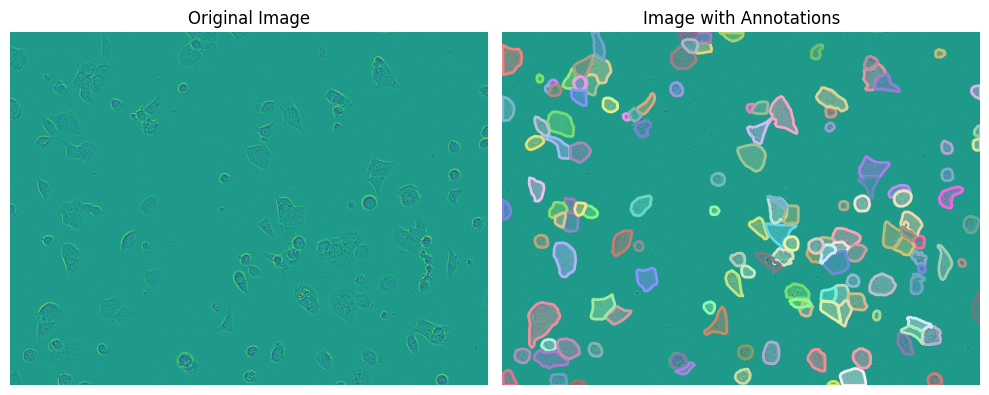

In [13]:
fig = plot_image_with_annotations(coco, image_ids[0])

# Dataset + Datalodaer

- we are merging all masks of different categories into one (just for simplification)

In [19]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, annotation_file, root_dir, transform_image, transform_mask):
        self.coco = COCO(annotation_file)
        self.image_ids = self.coco.getImgIds()
        self.root_dir = root_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):

        image_info = self.coco.loadImgs(self.image_ids[index])[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = Image.open(image_path).convert('L')  # Convert to single-channel grayscale

        annotation_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        annotations = self.coco.loadAnns(annotation_ids)

        mask = self.generate_mask(annotations, image.size)

        # transform
        image = self.transform_image(image)
        mask  = self.transform_mask(mask)

        return image, mask

    def generate_mask(self, annotations, image_size):
        mask_np = np.zeros(image_size[::-1], dtype=np.uint8)
        for ann in annotations:
            mask_ann = self.coco.annToMask(ann)
            mask_ann = mask_ann * ann['category_id']
            mask_ann = Image.fromarray(mask_ann).resize(image_size)
            mask_np = np.maximum(mask_np, np.array(mask_ann))
        mask = Image.fromarray(mask_np)
        return mask

In [20]:
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Lambda

transform_image = Compose([
    Resize((256, 256)),  # Resize images and masks to a specific size
    Lambda(lambda x: x.convert('L')),  # Convert to single-channel grayscale
    ToTensor(),  # Convert PIL images to tensors
])

class ToBinaryTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img)).float().unsqueeze(0)

transform_mask = Compose([
    Resize((256, 256)),  # Resize images and masks to a specific size
    Lambda(lambda x: x.convert('L')),  # Convert to single-channel grayscale
    ToBinaryTensor(),  # Convert PIL images to tensors, no (0,255) -> (0,1) scalling
])

In [21]:
root_dir = 'images/livecell_train_val_images/'
dataset = CocoSegmentationDataset(annotation_file, root_dir, transform_image=transform_image, transform_mask=transform_mask)

loading annotations into memory...
Done (t=4.66s)
creating index...
index created!


In [22]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Text(0.5, 1.0, 'Mask')

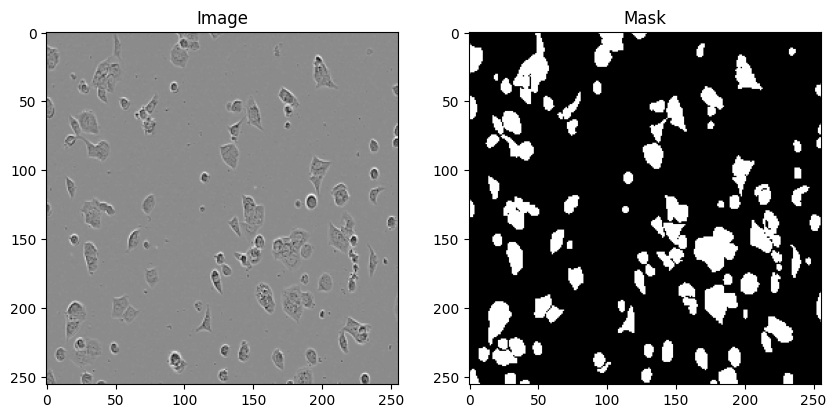

In [23]:
im, mask = dataset[0]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(im[0], cmap='gray')
ax.set_title('Image')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask[0], cmap='gray')
ax.set_title('Mask')

# Network